In [26]:
import pandas as pd
import re
import numpy as np
import os

def parse_user_blocks(lines, user):
    user_data = []
    i = 0

    while i < len(lines):
        line = lines[i]

        # Detect start of new TimeGuessr entry
        if line.startswith("TimeGuessr"):
            m = re.search(r"TimeGuessr #(\d+)\s+[—-]?\s*([\d,]+)/50,000", line)
            if m:
                day = int(m.group(1))
                total_score = int(m.group(2).replace(",", ""))
                rounds = []
                j = i + 1

                # --- CASE 1: Emoji keycap rounds (1️⃣⃣ … 5️⃣⃣ …) ---
                # Check if next lines have the numbered emoji format
                if j < len(lines) and re.search(r"[1-5]️⃣", lines[j]) and "🏆" in lines[j]:
                    rounds_found = 0
                    k = j
                    while k < len(lines) and rounds_found < 5:
                        line_text = lines[k]
                        # Look for the numbered emoji keycap pattern with trophy
                        if re.search(r"[1-5]️⃣", line_text) and "🏆" in line_text:
                            match = re.search(
                                r"🏆(\d+)\s*-\s*📅(\d+)y\s*-\s*🌍([\d.]+\s*\w+)", 
                                line_text
                            )
                            if match:
                                round_score = int(match.group(1))
                                time_dist = int(match.group(2))
                                geo_dist = match.group(3).strip()
                                rounds.append({
                                    "Round Score": round_score,
                                    "Time Distance": time_dist,
                                    "Geography Distance": geo_dist,
                                    "Time Guessed": np.nan,
                                    "Time Score": np.nan,
                                    "Geography Score": np.nan,
                                    "Geography": np.nan,
                                    "Time": np.nan
                                })
                                rounds_found += 1
                            k += 1
                        else:
                            break
                    i = k  # move past the last parsed round

                # --- CASE 2: Detailed format with scores (Year: X. Location: Y) ---
                elif j < len(lines) and "Year:" in lines[j] and "Location:" in lines[j]:
                    for k in range(j, j + 5):
                        if k >= len(lines):
                            break
                        # Updated pattern without location guess, optional country before year
                        detailed_match = re.search(
                            r"🌎([🟩🟨⬛️]*)\s*📅([🟩🟨⬛️]*)\s+(?:([^,]+),\s*)?(\d{3,4}),\s*([\d.]+\s*\w+)\.\s*Year:\s*(\d+)\.\s*Location:\s*(\d+)",
                            lines[k]
                        )
                        if detailed_match:
                            geo = detailed_match.group(1)
                            time = detailed_match.group(2)
                            country_guessed = detailed_match.group(3)  # May be None
                            time_guessed = int(detailed_match.group(4))
                            geography_distance = detailed_match.group(5).strip()
                            time_score = int(detailed_match.group(6))
                            geography_score = int(detailed_match.group(7))
                            round_score = time_score + geography_score
                            rounds.append({
                                "Round Score": round_score,
                                "Geography Distance": geography_distance,
                                "Time Distance": np.nan,
                                "Time Guessed": time_guessed,
                                "Time Score": time_score,
                                "Geography Score": geography_score,
                                "Geography": geo,
                                "Time": time
                            })
                    i += 6

                # --- CASE 3: Ultra-simplified format (year, distance only - no scores) ---
                elif j < len(lines) and lines[j].startswith("🌎"):
                    # Check if this is the simplified format by looking for comma and distance unit
                    test_line = lines[j]
                    # More flexible check - just needs year, comma, and number before km/m
                    if re.search(r"\d{3,4},\s*[\d.]+\s*k?m", test_line) and "Year:" not in test_line:
                        for k in range(j, j + 5):
                            if k >= len(lines):
                                break
                            line_text = lines[k]
                            # Match pattern: emojis, optional country, year, distance (no scores)
                            # Handle both "km" and "m", with optional space
                            simple_match = re.search(
                                r"🌎([🟩🟨⬛️]*)\s*📅([🟩🟨⬛️]*)\s+(?:([^,]+),\s*)?(\d{3,4}),\s*([\d.]+)\s*(k?m)",
                                line_text
                            )
                            if simple_match:
                                geo = simple_match.group(1)
                                time = simple_match.group(2)
                                country_guessed = simple_match.group(3)  # May be None
                                time_guessed = int(simple_match.group(4))
                                distance_num = simple_match.group(5)
                                distance_unit = simple_match.group(6)
                                geography_distance = f"{distance_num} {distance_unit}"
                                rounds.append({
                                    "Round Score": np.nan,
                                    "Geography Distance": geography_distance,
                                    "Time Distance": np.nan,
                                    "Time Guessed": time_guessed,
                                    "Time Score": np.nan,
                                    "Geography Score": np.nan,
                                    "Geography": geo,
                                    "Time": time
                                })
                            else:
                                # Debug: if match fails, try to see what's in the line
                                print(f"Failed to match line {k}: {line_text}")
                        i += 6
                    # Otherwise fall through to CASE 4
                    else:
                        for k in range(i + 1, i + 6):
                            if k < len(lines) and lines[k].startswith("🌎"):
                                r = re.search(r"🌎([🟩🟨⬛️]*)\s+📅([🟩🟨⬛️]*)", lines[k])
                                if r:
                                    geo = r.group(1)
                                    time = r.group(2)
                                    rounds.append({
                                        "Round Score": np.nan,
                                        "Geography": geo,
                                        "Geography Distance": np.nan,
                                        "Time": time,
                                        "Time Distance": np.nan,
                                        "Time Guessed": np.nan,
                                        "Time Score": np.nan,
                                        "Geography Score": np.nan
                                    })
                        i += 6

                # (Already handled in CASE 3 else block above)

                # --- Append rounds to user_data ---
                for rnum, rd in enumerate(rounds, start=1):
                    entry = {
                        "Timeguessr Day": day,
                        "Timeguessr Round": rnum,
                        "Total Score": total_score,
                        "Round Score": rd.get("Round Score", np.nan),
                        "Geography": rd.get("Geography", np.nan),
                        "Geography Distance": rd.get("Geography Distance", np.nan),
                        "Time": rd.get("Time", np.nan),
                        "Time Distance": rd.get("Time Distance", np.nan),
                        "Time Guessed": rd.get("Time Guessed", np.nan),
                        "Time Score": rd.get("Time Score", np.nan),
                        "Geography Score": rd.get("Geography Score", np.nan),
                    }
                    user_data.append(entry)
            else:
                i += 1
        else:
            i += 1

    # Convert to DataFrame and rename columns with user prefix
    df_user = pd.DataFrame(user_data)

    for col in ["Time","Geography"]:
        df_user[col] = (
            df_user[col]
            .astype(str)
            .str.replace("🟩", "O", regex=False)
            .str.replace("🟨", "%", regex=False)
            .str.replace("⬛", "X", regex=False)
            .apply(lambda x: re.sub(r"[\uFE0F\u200Dï¸]", "", x))  # remove hidden unicode
            .str.strip()
        )

    def convert_to_meters(value):
        """Convert distance strings like '1.6 km' or '45.1 m' to float meters."""
        if pd.isna(value):
            return np.nan

        val = str(value).strip().lower()

        # Extract numeric part
        try:
            num = float(val.split()[0])
        except:
            return np.nan

        # Convert based on unit
        if "km" in val:
            return num * 1000
        elif "m" in val:
            return num
        else:
            return np.nan  # unexpected unit

    df_user["Geography Distance"] = df_user["Geography Distance"].apply(convert_to_meters)

    # Set score to 5000 for "OOO"
    mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OOO")
    df_user.loc[mask, "Geography Score"] = 5000

    # Mask for rows where score is still NaN and distance is not NaN
    mask = df_user["Geography Score"].isna() & df_user["Geography Distance"].notna()
    dist = df_user.loc[mask, "Geography Distance"]

    # Distance-based score rules
    conditions = [
        (dist <= 50),
        (dist > 50) & (dist <= 1000),
        (dist > 1000) & (dist <= 5000),
        (dist > 5000) & (dist <= 100000),
        (dist > 100000) & (dist <= 1000000),
        (dist > 1000000) & (dist <= 2000000),
        (dist > 2000000) & (dist <= 3000000),
        (dist > 3000000) & (dist <= 6000000),
        (dist > 6000000)
    ]

    scores = [
        5000,
        5000 - (dist * 0.02),
        4980 - (dist * 0.016),
        4900 - (dist * 0.004),
        4500 - (dist * 0.001),
        3500 - (dist * 0.0005),
        2500 - (dist * 0.0003333),
        1500 - (dist * 0.0002),
        12
    ]

    df_user.loc[mask, "Geography Score"] = np.select(conditions, scores, default=np.nan)
    df_user["Geography Score"] = df_user["Geography Score"].clip(lower=12)

    # Geography Score min/max
    if "Geography Score" in df_user.columns:
        df_user["Geography Score (Min)"] = np.nan
        df_user["Geography Score (Max)"] = np.nan
        
        # If geography score exists, use it for both min and max
        mask = df_user["Geography Score"].notna()
        df_user.loc[mask, "Geography Score (Min)"] = df_user.loc[mask, "Geography Score"]
        df_user.loc[mask, "Geography Score (Max)"] = df_user.loc[mask, "Geography Score"]
        
        # For missing geography scores, set min/max based on pattern
        if "Geography" in df_user.columns:
            # OO% pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OO%")
            df_user.loc[mask, "Geography Score (Min)"] = 4750
            df_user.loc[mask, "Geography Score (Max)"] = 4999
            
            # OOX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OOX")
            df_user.loc[mask, "Geography Score (Min)"] = 4500
            df_user.loc[mask, "Geography Score (Max)"] = 4749
            
            # O%X pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "O%X")
            df_user.loc[mask, "Geography Score (Min)"] = 4250
            df_user.loc[mask, "Geography Score (Max)"] = 4499
            
            # OXX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OXX")
            df_user.loc[mask, "Geography Score (Min)"] = 3500
            df_user.loc[mask, "Geography Score (Max)"] = 4249
            
            # %XX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "%XX")
            df_user.loc[mask, "Geography Score (Min)"] = 2500
            df_user.loc[mask, "Geography Score (Max)"] = 3499
            
            # XXX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "XXX")
            df_user.loc[mask, "Geography Score (Min)"] = 12
            df_user.loc[mask, "Geography Score (Max)"] = 2499

    df_user = df_user.rename(columns={
        "Total Score": f"{user} Total Score",
        "Round Score": f"{user} Round Score",
        "Geography": f"{user} Geography",
        "Geography Distance": f"{user} Geography Distance",
        "Time": f"{user} Time",
        "Time Distance": f"{user} Time Distance",
        "Time Guessed": f"{user} Time Guessed",
        "Time Score": f"{user} Time Score",
        "Geography Score": f"{user} Geography Score",
        "Geography Score (Min)": f"{user} Geography Score (Min)",
        "Geography Score (Max)": f"{user} Geography Score (Max)"
    })

    return df_user


def parse_actuals(lines):
    actuals_data = []
    i = 0

    while i < len(lines):
        line = lines[i]

        # Detect start of TimeGuessr day
        if line.startswith("TimeGuessr #"):
            m = re.search(r"TimeGuessr #(\d+)", line)
            if m:
                day = int(m.group(1))

                # Parse the next 5 rounds
                for round_num in range(1, 6):
                    i += 1
                    if i < len(lines):
                        # Match pattern: "1. London, United Kingdom, 1970"
                        round_match = re.search(
                            r"^\d+\.\s+(.+?),\s+(.+?),\s+(\d{4})$",
                            lines[i]
                        )
                        if round_match:
                            city = round_match.group(1).strip()
                            country = round_match.group(2).strip()
                            year = int(round_match.group(3))

                            # --- Extract subdivision if city has parentheses ---
                            subdivision_match = re.search(r"\((.*?)\)", city)
                            if subdivision_match:
                                subdivision = subdivision_match.group(1).strip()
                                city = re.sub(r"\s*\(.*?\)", "", city).strip()
                            else:
                                subdivision = ""

                            actuals_data.append({
                                "Timeguessr Day": day,
                                "Timeguessr Round": round_num,
                                "City": city,
                                "Subdivision": subdivision,
                                "Country": country,
                                "Year": year
                            })
        i += 1

    return pd.DataFrame(actuals_data)


# --- Check if parsed CSVs already exist ---
michael_csv = "Data/Timeguessr_Michael_Parsed.csv"
sarah_csv   = "Data/Timeguessr_Sarah_Parsed.csv"
actuals_csv = "Data/Timeguessr_Actuals_Parsed.csv"

if os.path.exists(michael_csv) and os.path.exists(sarah_csv) and os.path.exists(actuals_csv):
    print("✅ Using existing parsed CSVs...")
    df_michael = pd.read_csv(michael_csv)
    df_sarah   = pd.read_csv(sarah_csv)
    df_actuals = pd.read_csv(actuals_csv)
else:
    print("🔄 Parsed CSVs not found — parsing from TXT files...")

    # --- Load user files ---
    with open("Data/TimeGuessr_Michael.txt", "r", encoding="utf-8") as f:
        michael_lines = [line.strip() for line in f if line.strip()]

    with open("Data/TimeGuessr_Sarah.txt", "r", encoding="utf-8") as f:
        sarah_lines = [line.strip() for line in f if line.strip()]

    with open("Data/TimeGuessr_Actuals.txt", "r", encoding="utf-8") as f:
        actuals_lines = [line.strip() for line in f if line.strip()]

    # --- Parse both users ---
    df_michael = parse_user_blocks(michael_lines, "Michael")
    df_michael.to_csv(michael_csv, index=False)

    df_sarah = parse_user_blocks(sarah_lines, "Sarah")
    df_sarah.to_csv(sarah_csv, index=False)

    df_actuals = parse_actuals(actuals_lines)
    df_actuals.to_csv(actuals_csv, index=False)

# --- Merge into one dataframe ---
df_all = pd.merge(df_michael, df_sarah, on=["Timeguessr Day", "Timeguessr Round"], how="outer")
df_all = pd.merge(df_all, df_actuals, on=["Timeguessr Day", "Timeguessr Round"], how="left")

# --- Calculate Time Distance if not already present ---
# For Michael
if "Michael Time Distance" in df_all.columns and "Michael Time Guessed" in df_all.columns:
    mask = df_all["Michael Time Distance"].isna() & df_all["Michael Time Guessed"].notna() & df_all["Year"].notna()
    df_all.loc[mask, "Michael Time Distance"] = abs(df_all.loc[mask, "Year"] - df_all.loc[mask, "Michael Time Guessed"])

# For Sarah
if "Sarah Time Distance" in df_all.columns and "Sarah Time Guessed" in df_all.columns:
    mask = df_all["Sarah Time Distance"].isna() & df_all["Sarah Time Guessed"].notna() & df_all["Year"].notna()
    df_all.loc[mask, "Sarah Time Distance"] = abs(df_all.loc[mask, "Year"] - df_all.loc[mask, "Sarah Time Guessed"])

# --- Add Date column first ---
start_date = pd.Timestamp("2025-03-20")
df_all["Date"] = start_date + pd.to_timedelta(df_all["Timeguessr Day"] - df_all["Timeguessr Day"].min(), unit="D")

# Move Date to first column, keep City, Country, Year early
cols = ["Date", "Timeguessr Day", "Timeguessr Round", "City", "Subdivision", "Country", "Year"] + [c for c in df_all.columns if c not in ["Date", "Timeguessr Day", "Timeguessr Round", "City", "Subdivision",  "Country", "Year"]]
df_all = df_all[cols]

# Sort and reset
df_all = df_all.sort_values(["Timeguessr Day", "Timeguessr Round"]).reset_index(drop=True)

# Handle Time scores
for player in ["Michael", "Sarah"]:
    time_col = f"{player} Time"
    time_score_col = f"{player} Time Score"
    time_dist_col = f"{player} Time Distance"
    
    # Set score to 5000 for "OOO"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "OOO")
    df_all.loc[mask, time_score_col] = 5000
    
    # Set score to 1000 for "%XX"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "%XX")
    df_all.loc[mask, time_score_col] = 1000
    
    # Set score to 0 for "XXX"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "XXX")
    df_all.loc[mask, time_score_col] = 0

    def calc_time_score(yearsOff):
        if pd.isna(yearsOff):
            return None
        yearsOff = float(yearsOff)

        if yearsOff == 0:
            return 5000
        elif yearsOff == 1:
            return 4950
        elif yearsOff == 2:
            return 4800
        elif yearsOff == 3:
            return 4600
        elif yearsOff == 4:
            return 4300
        elif yearsOff == 5:
            return 3900
        elif yearsOff in [6, 7]:
            return 3400
        elif yearsOff in [8, 9, 10]:
            return 2500
        elif 10 < yearsOff < 16:
            return 2000
        elif 15 < yearsOff < 21:
            return 1000
        else:
            return 0
        
    # Apply the conversion
    mask = df_all[time_score_col].isna()  # only fill if not already set by OOO/%XX/XXX
    df_all.loc[mask, time_score_col] = df_all.loc[mask, time_dist_col].apply(calc_time_score)
    
# --- Add min/max columns for Time and Geography scores ---
for player in ["Michael", "Sarah"]:
    # Time Score min/max
    time_score_col = f"{player} Time Score"
    time_col = f"{player} Time"
    time_min_col = f"{player} Time Score (Min)"
    time_max_col = f"{player} Time Score (Max)"
    
    if time_score_col in df_all.columns:
        df_all[time_min_col] = np.nan
        df_all[time_max_col] = np.nan
        
        # If time score exists, use it for both min and max
        mask = df_all[time_score_col].notna()
        df_all.loc[mask, time_min_col] = df_all.loc[mask, time_score_col]
        df_all.loc[mask, time_max_col] = df_all.loc[mask, time_score_col]
        
        # For missing time scores, set min/max based on pattern
        if time_col in df_all.columns:
            # OO% pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OO%")
            df_all.loc[mask, time_min_col] = 4800
            df_all.loc[mask, time_max_col] = 4950
            
            # OOX pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OOX")
            df_all.loc[mask, time_min_col] = 4300
            df_all.loc[mask, time_max_col] = 4600
            
            # O%X pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "O%X")
            df_all.loc[mask, time_min_col] = 3400
            df_all.loc[mask, time_max_col] = 3900
            
            # OXX pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OXX")
            df_all.loc[mask, time_min_col] = 2000
            df_all.loc[mask, time_max_col] = 2500   

# --- Fill missing Round Scores if both component scores exist ---
for player in ["Michael", "Sarah"]:
    time_col = f"{player} Time Score"
    geo_col = f"{player} Geography Score"
    round_col = f"{player} Round Score"

    if all(c in df_all.columns for c in [time_col, geo_col, round_col]):
        mask = df_all[round_col].isna() & df_all[time_col].notna() & df_all[geo_col].notna()
        df_all.loc[mask, round_col] = df_all.loc[mask, time_col] + df_all.loc[mask, geo_col]

# --- Save ---
df_all.to_csv("Data/Timeguessr_Stats.csv", index=False)
print("✅ Saved combined stats to Timeguessr_Stats.csv")

df_all

🔄 Parsed CSVs not found — parsing from TXT files...
✅ Saved combined stats to Timeguessr_Stats.csv


,Date,Timeguessr Day,Timeguessr Round,City,Subdivision,Country,Year,Michael Total Score,Michael Round Score,Michael Geography,...,Sarah Time Distance,Sarah Time Guessed,Sarah Time Score,Sarah Geography Score,Sarah Geography Score (Min),Sarah Geography Score (Max),Michael Time Score (Min),Michael Time Score (Max),Sarah Time Score (Min),Sarah Time Score (Max)
0,2025-03-20,658,1,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,2500.0,NaN,NaN
1,2025-03-20,658,2,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,5000.0,NaN,NaN
2,2025-03-20,658,3,NaN,NaN,NaN,NaN,40428.0,NaN,OXX,...,NaN,NaN,NaN,NaN,NaN,NaN,4800.0,4950.0,NaN,NaN
3,2025-03-20,658,4,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,4800.0,4950.0,NaN,NaN
4,2025-03-20,658,5,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2025-11-03,886,1,Moscow,,Russia,1990.0,41639.0,9996.186,OO%,...,0.0,1990.0,5000.0,4959.200,4959.200,4959.200,5000.0,5000.0,5000.0,5000.0
581,2025-11-03,886,2,Berlin,Berlin,Germany,1955.0,41639.0,5866.000,OO%,...,15.0,1940.0,2000.0,4861.600,4861.600,4861.600,1000.0,1000.0,2000.0,2000.0
582,2025-11-03,886,3,Santiago,,Chile,1910.0,41639.0,7444.800,OO%,...,3.0,1913.0,4600.0,12.000,12.000,12.000,2500.0,2500.0,4600.0,4600.0
583,2025-11-03,886,4,Lisbon,,Portugal,1982.0,41639.0,8382.522,OO%,...,8.0,1990.0,2500.0,4805.200,4805.200,4805.200,3400.0,3400.0,2500.0,2500.0


In [27]:
def format_distance(x):
    if pd.isna(x):
        return np.nan
    elif x < 1000:
        return f"{int(round(x))} m"
    else:
        return f"{round(x/1000, 2)} km"  # round to 2 decimals


# Custom pattern order
pattern_order = ["OOO", "OO%", "OOX", "O%X", "OXX", "%XX", "XXX"]


def get_ordered_stats(df, col_prefix, score_col, distance_cols=None, format_geography=False):
    combined_frames = []
    for player in ["Michael", "Sarah"]:
        cols = [f"{player} {col_prefix}", f"{player} {score_col}"]
        if distance_cols:
            cols += [f"{player} {dc}" for dc in distance_cols]
        rename_dict = {f"{player} {col_prefix}": "Cat",  # rename main category
                       f"{player} {score_col}": score_col}
        if distance_cols:
            rename_dict.update({f"{player} {dc}": dc for dc in distance_cols})
        combined_frames.append(df[cols].rename(columns=rename_dict))

    combined = pd.concat(combined_frames, ignore_index=True)

    # --- Compute Total Cases (before dropping score NaNs) ---
    total_cases = combined.groupby("Cat").size().reset_index(name="Total Cases")

    # --- Keep only valid category values ---
    valid_mask = combined["Cat"].astype(str).str.strip() != ""
    combined = combined[valid_mask]

    # Convert score to numeric
    combined[score_col] = pd.to_numeric(combined[score_col], errors="coerce")

    # --- Compute Known Cases (only with known scores) ---
    known_cases = (
        combined[combined[score_col].notna()]
        .groupby("Cat")
        .size()
        .reset_index(name="Known Cases")
    )

    # --- Clean and convert distances ---
    if distance_cols:
        for dc in distance_cols:
            # Convert numeric part
            combined[dc] = combined[dc].astype(str).str.extract(r"([\d\.]+)")[0]
            combined[dc] = pd.to_numeric(combined[dc], errors="coerce")

            # Detect km and convert to meters
            is_km = df[[f"Michael {dc}", f"Sarah {dc}"]].astype(str).apply(lambda s: s.str.contains("km", na=False))
            is_km_flat = is_km.stack().reset_index(drop=True)
            combined.loc[is_km_flat[is_km_flat].index, dc] *= 1000

    # --- Compute score stats ---
    stats = combined.groupby("Cat")[score_col].agg(["min", "max"]).reset_index()
    stats = stats.rename(columns={"min": "Min Score", "max": "Max Score"})

    # --- Compute min/max distances ---
    if distance_cols:
        for dc in distance_cols:
            dc_stats = combined.groupby("Cat")[dc].agg(["min", "max"]).reset_index()

            if format_geography:
                dc_stats["min"] = dc_stats["min"].apply(format_distance)
                dc_stats["max"] = dc_stats["max"].apply(format_distance)
            else:
                dc_stats["min"] = dc_stats["min"].astype("Int64")
                dc_stats["max"] = dc_stats["max"].astype("Int64")

            dc_stats = dc_stats.rename(columns={"min": "Min Dist", "max": "Max Dist"})
            stats = stats.merge(dc_stats, on="Cat", how="left")

    # --- Merge counts ---
    stats = total_cases.merge(stats, on="Cat", how="left")
    stats = stats.merge(known_cases, on="Cat", how="left")

    # --- Reorder columns so Known Cases follows Total Cases ---
    col_order = ["Cat", "Total Cases", "Known Cases"] + [c for c in stats.columns if c not in ["Cat", "Total Cases", "Known Cases"]]
    stats = stats[col_order]

    # --- Reindex by custom order ---
    stats = stats.set_index("Cat").reindex(pattern_order).reset_index()

    return stats


# --- Run for Geography and Time ---
geo_stats = get_ordered_stats(
    df_all, "Geography", "Geography Score",
    distance_cols=["Geography Distance"], format_geography=True
)
time_stats = get_ordered_stats(
    df_all, "Time", "Time Score",
    distance_cols=["Time Distance"], format_geography=False
)

print("🌍 Geography pattern stats:")
print(geo_stats)

print("\n📅 Time pattern stats:")
print(time_stats)


🌍 Geography pattern stats:
   Cat  Total Cases  Known Cases  Min Score  Max Score   Min Dist    Max Dist
0  OOO           89           89    5000.00  5000.0000        6 m        46 m
1  OO%          538           90    4760.00  5000.0000       14 m     35.0 km
2  OOX           37            6    4584.40  4740.4000    39.9 km     78.9 km
3  O%X           76            6    4259.20  4393.0000   107.0 km    240.8 km
4  OXX          166           16    3616.80  4201.1000   298.9 km    883.2 km
5  %XX           57            2    2926.95  2942.5000  1115.0 km   1146.1 km
6  XXX           92            7      12.00  1823.0677  2031.0 km  12640.0 km

📅 Time pattern stats:
   Cat  Total Cases  Known Cases  Min Score  Max Score  Min Dist  Max Dist
0  OOO          160          160     5000.0     5000.0         0         0
1  OO%          205           28     4800.0     5000.0         0         2
2  OOX          142           17     4300.0     4600.0         3         4
3  O%X          184       

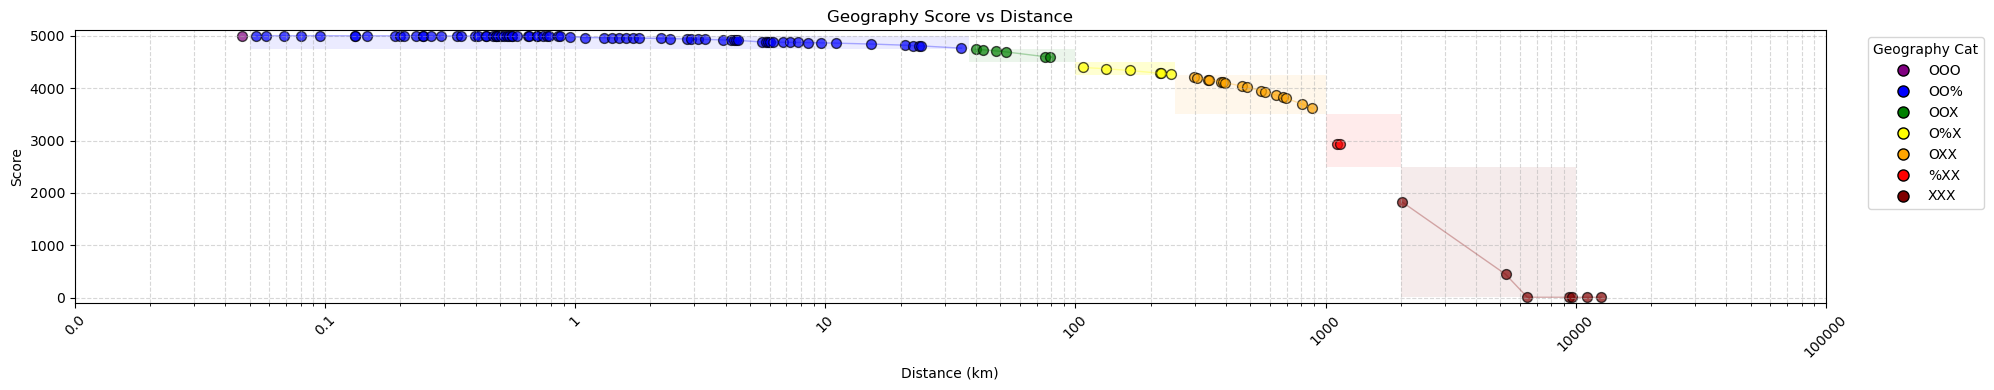

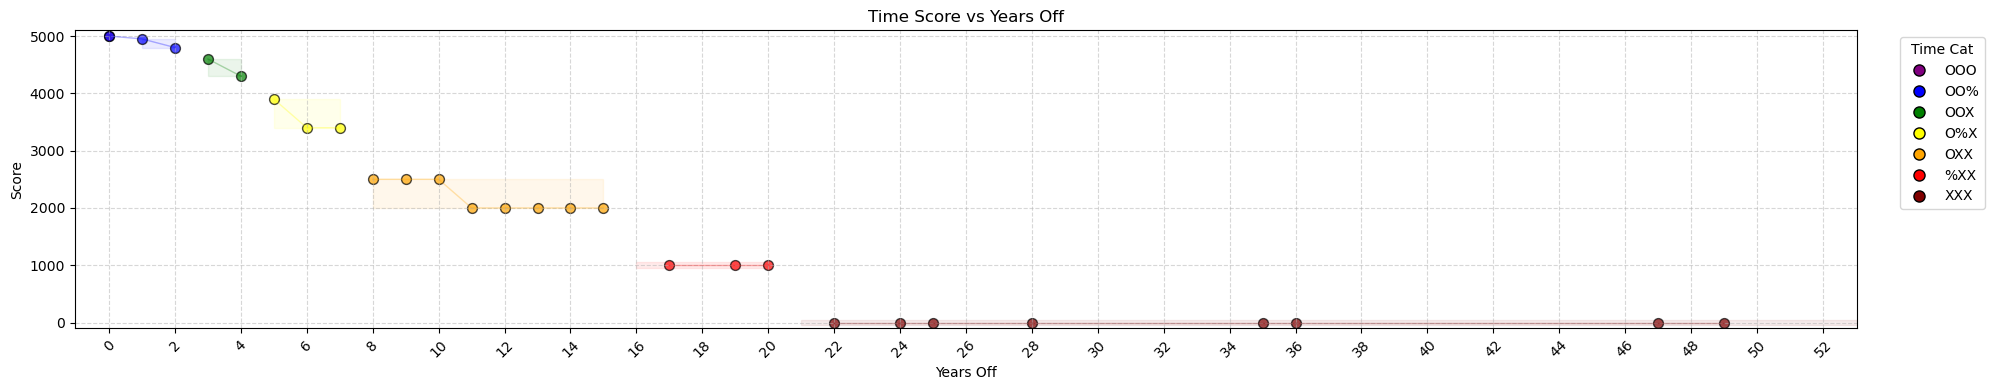

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle


# --- Helper to clean distances ---
def clean_distance(series):
    s = series.astype(str).str.strip().str.lower()
    s_num = s.str.extract(r'([\d\.]+)')[0].astype(float)
    s_num[s.str.contains("km", na=False)] *= 1000
    return s_num


# --- Define fixed category order and colors ---
pattern_order = ["OOO", "OO%", "OOX", "O%X", "OXX", "%XX", "XXX"]
pattern_colors = {
    "OOO": "purple",
    "OO%": "blue",
    "OOX": "green",
    "O%X": "yellow",
    "OXX": "orange",
    "%XX": "red",
    "XXX": "maroon"
}


# --- Scatter + line for Geography (log scale, fixed legend/colors) ---
def plot_geography_score_vs_distance_unique(df, score_col, distance_col_prefix, title):
    df_geo = pd.DataFrame({
        "Score": pd.concat([df[f"Michael {score_col}"], df[f"Sarah {score_col}"]], ignore_index=True),
        "Distance": pd.concat([df[f"Michael {distance_col_prefix}"], df[f"Sarah {distance_col_prefix}"]], ignore_index=True),
        "Cat": pd.concat([df["Michael Geography"], df["Sarah Geography"]], ignore_index=True)
    })

    df_geo["Distance_km"] = clean_distance(df_geo["Distance"]) / 1000
    df_geo = df_geo.dropna(subset=["Score", "Distance_km", "Cat"])
    df_geo = df_geo[df_geo["Distance_km"] > 0]

    df_plot = df_geo.groupby(["Cat", "Distance_km"], as_index=False).mean().sort_values("Distance_km")

    # Keep only one instance of 5000 (largest distance)
    if (df_plot["Score"] == 5000).any():
        max_dist_5000 = df_plot.loc[df_plot["Score"] == 5000, "Distance_km"].max()
        df_plot = df_plot[(df_plot["Score"] != 5000) | (df_plot["Distance_km"] == max_dist_5000)]

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.set_xscale("log")
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(True, which="both", linestyle='--', alpha=0.5)

    # --- Background shading by score tiers ---
    shade_rules = [
        (4750, 4999, "blue"),     # 🟩🟩🟨
        (4500, 4749, "green"),    # 🟩🟩⬛️
        (4250, 4499, "yellow"),   # 🟩🟨⬛️
        (3500, 4249, "orange"),   # 🟩⬛️⬛️
        (2500, 3499, "red"),      # 🟨⬛️⬛️
        (12, 2499, "maroon")       # ⬛️⬛️⬛️
    ]

    for ymin, ymax, color in shade_rules:
        if color == "blue":
            rect = Rectangle(
                (0.05, ymin), 
                37.5 - 0.05, 
                ymax - ymin,
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "green":
            rect = Rectangle(
                (37.5, ymin),
                100 - 37.5,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "yellow":
            rect = Rectangle(
                (100, ymin),
                250 - 100,
                ymax - ymin, 
                facecolor=color,
                alpha=0.18,
                zorder=0
            )
        elif color == "orange":
            rect = Rectangle(
                (250, ymin),
                1000 - 250,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "red":
            rect = Rectangle(
                (1000, ymin),
                2000 - 1000,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "maroon":
            rect = Rectangle(
                (2000, ymin),
                10000 - 2000,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        ax.add_patch(rect)

    # --- Plot each category ---
    for cat in pattern_order:
        color = pattern_colors[cat]
        sub = df_plot[df_plot["Cat"] == cat]
        if not sub.empty:
            ax.scatter(sub["Distance_km"], sub["Score"], s=50, edgecolor='k', color=color, alpha=0.7)
            ax.plot(sub["Distance_km"], sub["Score"], color=color, alpha=0.3, linewidth=1)
        else:
            ax.scatter([], [], color=color, label=cat)

    # Log tick formatting (decimal below 1)
    min_x = max(df_plot["Distance_km"].min(), 0.001)
    max_x = df_plot["Distance_km"].max()
    log_min = int(np.floor(np.log10(min_x)))
    log_max = int(np.ceil(np.log10(max_x)))
    ticks = [10 ** i for i in range(log_min, log_max + 1)]
    tick_labels = [f"{t:.1f}" if t < 1 else f"{int(t)}" for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45)

    ax.set_ylim(-100, 5100)

    # Custom legend handles (circles only)
    handles = [
        mlines.Line2D([], [], color=pattern_colors[cat], marker='o', linestyle='None',
                      markersize=8, label=cat, markeredgecolor='k')
        for cat in pattern_order
    ]

    ax.legend(handles=handles, title="Geography Cat", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# --- Scatter + line for Time (linear scale, fixed legend/colors) ---
def plot_time_score_vs_distance_unique(df, score_col, distance_col_prefix, title):
    df_time = pd.DataFrame({
        "Score": pd.concat([df[f"Michael {score_col}"], df[f"Sarah {score_col}"]], ignore_index=True),
        "YearsOff": pd.concat([df[f"Michael {distance_col_prefix}"], df[f"Sarah {distance_col_prefix}"]], ignore_index=True),
        "Cat": pd.concat([df["Michael Time"], df["Sarah Time"]], ignore_index=True)
    })

    df_time["YearsOff"] = pd.to_numeric(df_time["YearsOff"], errors="coerce")
    df_time = df_time.dropna(subset=["Score", "YearsOff", "Cat"])

    df_plot = df_time.groupby(["Cat", "YearsOff"], as_index=False).mean().sort_values("YearsOff")

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.set_xlabel("Years Off")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- Background shading by score tiers (calcTime rules) ---
    # approximate intervals derived from your discrete values
    # --- Axis setup before shading (so we know the full X range) ---
    max_year = int(np.ceil(df_plot["YearsOff"].max() / 2) * 2) + 2
    x_buffer = 0.02 * max_year
    ax.set_xlim(-x_buffer, max_year + x_buffer)
    ax.set_ylim(-100, 5100)

    # --- Background shading by score tiers (calcTime rules) ---
    shade_rules = [
        (4800, 4950, "blue"),
        (4300, 4600, "green"),
        (3400, 3900, "yellow"),
        (2000, 2500, "orange"),
        (950, 1050, "red"),
        (-50, 50, "maroon")
    ]
    x_min, x_max = ax.get_xlim()

    for ymin, ymax, color in shade_rules:
        if color == "blue":
            ax.axhspan(ymin, ymax, xmin=(1 - x_min) / (x_max - x_min), xmax=(2 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "green":
            ax.axhspan(ymin, ymax, xmin=(3 - x_min) / (x_max - x_min), xmax=(4 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "yellow":
            ax.axhspan(ymin, ymax, xmin=(5 - x_min) / (x_max - x_min), xmax=(7 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "orange":
            ax.axhspan(ymin, ymax, xmin=(8 - x_min) / (x_max - x_min), xmax=(15 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "red":
            ax.axhspan(ymin, ymax, xmin=(16 - x_min) / (x_max - x_min), xmax=(20 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "maroon":
            ax.axhspan(ymin, ymax, xmin=(21 - x_min) / (x_max - x_min), xmax=1.0,
                       color=color, alpha=0.08, zorder=0)
        else:
            ax.axhspan(ymin, ymax, color=color, alpha=0.08, zorder=0)



    # --- Plot each category ---
    for cat in pattern_order:
        color = pattern_colors[cat]
        sub = df_plot[df_plot["Cat"] == cat]
        if not sub.empty:
            ax.scatter(sub["YearsOff"], sub["Score"], s=50, edgecolor='k', color=color, alpha=0.7)
            ax.plot(sub["YearsOff"], sub["Score"], color=color, alpha=0.3, linewidth=1)
        else:
            ax.scatter([], [], color=color, label=cat)

    # --- Axis formatting ---
    max_year = int(np.ceil(df_plot["YearsOff"].max() / 2) * 2) + 2
    ax.set_xticks(np.arange(0, max_year + 1, 2))
    ax.set_xticklabels(np.arange(0, max_year + 1, 2), rotation=45)

    x_buffer = 0.02 * max_year
    ax.set_xlim(-x_buffer, max_year + x_buffer)
    ax.set_ylim(-100, 5100)

    # --- Custom legend (circles only) ---
    handles = [
        mlines.Line2D([], [], color=pattern_colors[cat], marker='o', linestyle='None',
                      markersize=8, label=cat, markeredgecolor='k')
        for cat in pattern_order
    ]
    ax.legend(handles=handles, title="Time Cat", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# --- Run plots ---
plot_geography_score_vs_distance_unique(df_all, "Geography Score", "Geography Distance", "Geography Score vs Distance")
plot_time_score_vs_distance_unique(df_all, "Time Score", "Time Distance", "Time Score vs Years Off")


In [29]:
# --- Perfect score summary by player with percentages ---
data = []

for player in ["Michael", "Sarah"]:
    time_score_col = f"{player} Time Score"
    geo_score_col = f"{player} Geography Score"
    round_score_col = f"{player} Round Score"
    total_col = f"{player} Total Score"

    # Denominator: rounds where player has a total score (i.e., played)
    total_rounds = df_all[total_col].notna().sum()

    # Numerators: perfect score counts
    time_count = (df_all[time_score_col] == 5000).sum()
    geo_count = (df_all[geo_score_col] == 5000).sum()
    round_count = (df_all[round_score_col] == 10000).sum()

    # Percentages
    time_pct = time_count / total_rounds * 100 if total_rounds else np.nan
    geo_pct = geo_count / total_rounds * 100 if total_rounds else np.nan
    round_pct = round_count / total_rounds * 100 if total_rounds else np.nan

    data.append({
        "Player": player,
        "Time = 5000": time_count,
        "Time %": f"{time_pct:.1f}%",
        "Geography = 5000": geo_count,
        "Geography %": f"{geo_pct:.1f}%",
        "Round = 10000": round_count,
        "Round %": f"{round_pct:.1f}%"
    })

perfect_summary = pd.DataFrame(data)
perfect_summary


,Player,Time = 5000,Time %,Geography = 5000,Geography %,Round = 10000,Round %
0,Michael,100,17.4%,56,9.7%,15,2.6%
1,Sarah,65,13.3%,35,7.1%,8,1.6%


In [30]:
#Day of Week

# Ensure Date is datetime
df_all["Date"] = pd.to_datetime(df_all["Date"])

# Extract day of the week
df_all["DayOfWeek"] = df_all["Date"].dt.day_name()

# Group by day of week
avg_scores = (
    df_all.groupby("DayOfWeek")[["Michael Total Score", "Sarah Total Score"]]
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

# Count unique dates per weekday
unique_dates = (
    df_all.groupby("DayOfWeek")["Date"]
    .nunique()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

# Combine results
avg_scores["Unique Dates"] = unique_dates

avg_scores


,Michael Total Score,Sarah Total Score,Unique Dates
DayOfWeek,,,
Monday,40632.857143,38286.666667,21.0
Tuesday,40152.416667,35597.095238,24.0
Wednesday,39918.333333,38754.909091,25.0
Thursday,38536.250000,35300.312500,24.0
Friday,40491.409091,37394.952381,23.0
Saturday,NaN,NaN,NaN
Sunday,NaN,NaN,NaN


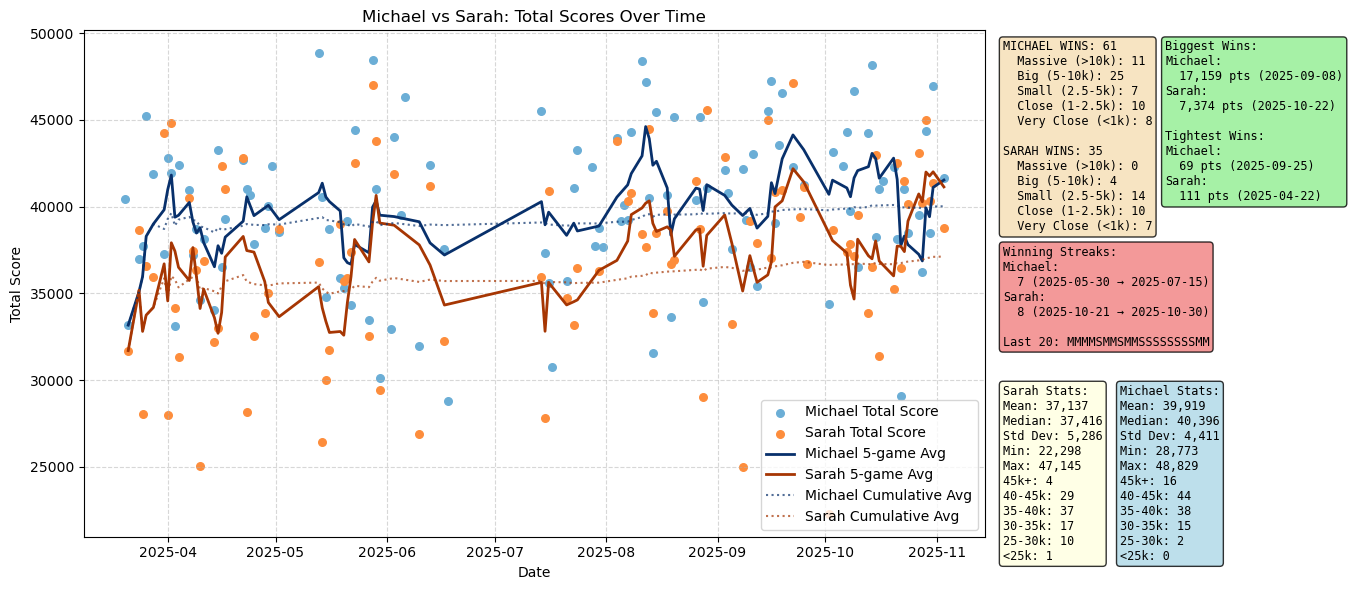

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare figure with text space on the right
fig, ax = plt.subplots(figsize=(14, 6))

# Get only the first row for each Timeguessr Day
df_daily = df_all.groupby("Timeguessr Day").first().reset_index()

# Drop NaN values for each player separately
mask = df_daily[["Date", "Michael Total Score", "Sarah Total Score"]].dropna()

# Sort by date (important for rolling calculations)
mask = mask.sort_values("Date").reset_index(drop=True)

# --- Rolling averages (10 games each) ---
mask["Michael Rolling Avg"] = mask["Michael Total Score"].rolling(window=5, min_periods=1).mean()
mask["Sarah Rolling Avg"] = mask["Sarah Total Score"].rolling(window=5, min_periods=1).mean()

# # --- Highlight band for last 5-game window range (min to max) ---
# window = 5

# # Compute rolling min and max for Michael and Sarah
# mask["Michael Rolling Min"] = mask["Michael Total Score"].rolling(window=window, min_periods=1).min()
# mask["Michael Rolling Max"] = mask["Michael Total Score"].rolling(window=window, min_periods=1).max()
# mask["Sarah Rolling Min"] = mask["Sarah Total Score"].rolling(window=window, min_periods=1).min()
# mask["Sarah Rolling Max"] = mask["Sarah Total Score"].rolling(window=window, min_periods=1).max()

# # Add shaded bands for the 5-game rolling range
# ax.fill_between(
#     mask["Date"],
#     mask["Michael Rolling Min"],
#     mask["Michael Rolling Max"],
#     color='#6baed6',
#     alpha=0.15,
#     label="Michael 5-game Range"
# )
# ax.fill_between(
#     mask["Date"],
#     mask["Sarah Rolling Min"],
#     mask["Sarah Rolling Max"],
#     color='#fd8d3c',
#     alpha=0.15,
#     label="Sarah 5-game Range"
# )

# --- Cumulative averages (average of all games up to that point) ---
mask["Michael Cumulative Avg"] = mask["Michael Total Score"].expanding().mean()
mask["Sarah Cumulative Avg"] = mask["Sarah Total Score"].expanding().mean()

# Calculate wins (only for dates where both players have scores)
score_diff = mask["Michael Total Score"] - mask["Sarah Total Score"]

# Create wins_array: 'M' for Michael win, 'S' for Sarah win, 'T' for tie
wins_array = []
for diff in score_diff:
    if diff > 0:
        wins_array.append('M')
    elif diff < 0:
        wins_array.append('S')
    else:
        wins_array.append('T')

# Michael wins
michael_massive_wins = (score_diff > 10000).sum()
michael_big_wins = ((score_diff > 5000) & (score_diff <= 10000)).sum()
michael_small_wins = ((score_diff > 2500) & (score_diff <= 5000)).sum()
michael_close_wins = ((score_diff > 1000) & (score_diff <= 2500)).sum()
michael_very_close_wins = ((score_diff > 0) & (score_diff <= 1000)).sum()

# Sarah wins
sarah_massive_wins = (score_diff < -10000).sum()
sarah_big_wins = ((score_diff < -5000) & (score_diff >= -10000)).sum()
sarah_small_wins = ((score_diff < -2500) & (score_diff >= -5000)).sum()
sarah_close_wins = ((score_diff < -1000) & (score_diff >= -2500)).sum()
sarah_very_close_wins = ((score_diff < 0) & (score_diff >= -1000)).sum()

# Ties
ties = (score_diff == 0).sum()

# Total wins
michael_wins = michael_massive_wins + michael_big_wins + michael_small_wins + michael_close_wins + michael_very_close_wins
sarah_wins = sarah_massive_wins + sarah_big_wins + sarah_small_wins + sarah_close_wins + sarah_very_close_wins

# --- Scatter plots of scores ---
ax.scatter(df_daily["Date"], df_daily["Michael Total Score"], color='#6baed6', label="Michael Total Score", s=30)
ax.scatter(df_daily["Date"], df_daily["Sarah Total Score"], color='#fd8d3c', label="Sarah Total Score", s=30)

# --- Rolling average lines ---
ax.plot(mask["Date"], mask["Michael Rolling Avg"], color='#08306b', linewidth=2, linestyle='-', label="Michael 5-game Avg")
ax.plot(mask["Date"], mask["Sarah Rolling Avg"], color='#a63603', linewidth=2, linestyle='-', label="Sarah 5-game Avg")

# --- Faint dotted cumulative average lines ---
ax.plot(mask["Date"], mask["Michael Cumulative Avg"], color='#08306b', linewidth=1.5, linestyle=':', alpha=0.7, label="Michael Cumulative Avg")
ax.plot(mask["Date"], mask["Sarah Cumulative Avg"], color='#a63603', linewidth=1.5, linestyle=':', alpha=0.7, label="Sarah Cumulative Avg")

# Formatting
ax.set_title("Michael vs Sarah: Total Scores Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Score")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# --- Statistics ---
michael_scores = df_daily["Michael Total Score"].dropna()
sarah_scores = df_daily["Sarah Total Score"].dropna()

michael_stats = {
    'Mean': michael_scores.mean(),
    'Median': michael_scores.median(),
    'Std Dev': michael_scores.std(),
    'Min': michael_scores.min(),
    'Max': michael_scores.max(),
    '45k+': (michael_scores >= 45000).sum(),
    '40-45k': ((michael_scores >= 40000) & (michael_scores < 45000)).sum(),
    '35-40k': ((michael_scores >= 35000) & (michael_scores < 40000)).sum(),
    '30-35k': ((michael_scores >= 30000) & (michael_scores < 35000)).sum(),
    '25-30k': ((michael_scores >= 25000) & (michael_scores < 30000)).sum(),
    '<25k': (michael_scores < 25000).sum()
}

sarah_stats = {
    'Mean': sarah_scores.mean(),
    'Median': sarah_scores.median(),
    'Std Dev': sarah_scores.std(),
    'Min': sarah_scores.min(),
    'Max': sarah_scores.max(),
    '45k+': (sarah_scores >= 45000).sum(),
    '40-45k': ((sarah_scores >= 40000) & (sarah_scores < 45000)).sum(),
    '35-40k': ((sarah_scores >= 35000) & (sarah_scores < 40000)).sum(),
    '30-35k': ((sarah_scores >= 30000) & (sarah_scores < 35000)).sum(),
    '25-30k': ((sarah_scores >= 25000) & (sarah_scores < 30000)).sum(),
    '<25k': (sarah_scores < 25000).sum()
}

# --- Win summary box ---
textstr = f'MICHAEL WINS: {michael_wins}\n'
textstr += f'  Massive (>10k): {michael_massive_wins}\n'
textstr += f'  Big (5-10k): {michael_big_wins}\n'
textstr += f'  Small (2.5-5k): {michael_small_wins}\n'
textstr += f'  Close (1-2.5k): {michael_close_wins}\n'
textstr += f'  Very Close (<1k): {michael_very_close_wins}\n\n'
textstr += f'SARAH WINS: {sarah_wins}\n'
textstr += f'  Massive (>10k): {sarah_massive_wins}\n'
textstr += f'  Big (5-10k): {sarah_big_wins}\n'
textstr += f'  Small (2.5-5k): {sarah_small_wins}\n'
textstr += f'  Close (1-2.5k): {sarah_close_wins}\n'
textstr += f'  Very Close (<1k): {sarah_very_close_wins}'
if ties > 0:
    textstr += f'\n\nTies: {ties}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=8.5,
        verticalalignment='top', bbox=props, family='monospace')

# --- Winning streaks ---
def find_all_streaks(arr, dates, player, min_length=1):
    streaks = []
    current_streak = 0
    streak_start = None

    for i, result in enumerate(arr):
        if result == player:
            if current_streak == 0:
                streak_start = dates[i]
            current_streak += 1
        else:
            if current_streak >= min_length:
                streaks.append((current_streak, streak_start, dates[i-1]))
            current_streak = 0

    # Check if streak continued to the end
    if current_streak >= min_length:
        streaks.append((current_streak, streak_start, dates[-1]))

    return streaks

def fmt_range(start, end):
    if start is None or end is None:
        return "—"
    if start == end:
        return start.strftime('%Y-%m-%d')
    return f"{start.strftime('%Y-%m-%d')} → {end.strftime('%Y-%m-%d')}"

# --- Process streaks ---
dates = [pd.Timestamp(d).to_pydatetime() for d in mask["Date"].values]

# Michael (all longest streaks)
michael_streaks = find_all_streaks(wins_array, dates, 'M', min_length=1)
if michael_streaks:
    max_length = max(s[0] for s in michael_streaks)
    michael_top = [s for s in michael_streaks if s[0] == max_length]
else:
    michael_top = [(0, None, None)]

# Sarah (all longest streaks)
sarah_streaks = find_all_streaks(wins_array, dates, 'S', min_length=1)
if sarah_streaks:
    max_length = max(s[0] for s in sarah_streaks)
    sarah_top = [s for s in sarah_streaks if s[0] == max_length]
else:
    sarah_top = [(0, None, None)]

# --- Last 20 games ---
last_twenty = ''.join(wins_array[-20:])

# --- Build text ---
streaks_text = "Winning Streaks:\n"

streaks_text += "Michael:\n"
for streak in michael_top:
    streaks_text += f"  {streak[0]} ({fmt_range(streak[1], streak[2])})\n"

streaks_text += "Sarah:\n"
for streak in sarah_top:
    streaks_text += f"  {streak[0]} ({fmt_range(streak[1], streak[2])})\n"

streaks_text += f"\nLast 20: {last_twenty}"

props_streaks = dict(boxstyle='round', facecolor='lightcoral', alpha=0.8)
ax.text(1.02, 0.575, streaks_text, transform=ax.transAxes, fontsize=8.5,
        verticalalignment='top', bbox=props_streaks, family='monospace')



# --- Stats boxes ---
michael_text = 'Michael Stats:\n'
for k, v in michael_stats.items():
    if k in ['Mean', 'Median', 'Std Dev', 'Min', 'Max']:
        michael_text += f'{k}: {v:,.0f}\n'
    else:
        michael_text += f'{k}: {v}\n'
props_michael = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(1.15, 0.3, michael_text.rstrip('\n'), transform=ax.transAxes, fontsize=8.5,
        verticalalignment='top', bbox=props_michael, family='monospace')

sarah_text = 'Sarah Stats:\n'
for k, v in sarah_stats.items():
    if k in ['Mean', 'Median', 'Std Dev', 'Min', 'Max']:
        sarah_text += f'{k}: {v:,.0f}\n'
    else:
        sarah_text += f'{k}: {v}\n'
props_sarah = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
ax.text(1.02, 0.3, sarah_text.rstrip('\n'), transform=ax.transAxes, fontsize=8.5,
        verticalalignment='top', bbox=props_sarah, family='monospace')

# --- Biggest and Tightest Wins (Top 1 for each) ---
mask["Score Diff"] = mask["Michael Total Score"] - mask["Sarah Total Score"]

# Sort differences (positive = Michael win, negative = Sarah win)
michael_wins_df = mask[mask["Score Diff"] > 0].sort_values("Score Diff", ascending=False)
sarah_wins_df = mask[mask["Score Diff"] < 0].sort_values("Score Diff", ascending=True)

# --- Top 1 Biggest Wins ---
top1_michael_big = michael_wins_df.head(1)[["Date", "Score Diff"]]
top1_sarah_big = sarah_wins_df.head(1)[["Date", "Score Diff"]]

# --- Top 1 Tightest Wins (closest nonzero differences) ---
top1_michael_tight = michael_wins_df.sort_values("Score Diff", ascending=True).head(1)[["Date", "Score Diff"]]
top1_sarah_tight = sarah_wins_df.sort_values("Score Diff", ascending=False).head(1)[["Date", "Score Diff"]]

# --- Format helper ---
def fmt_rows(df, invert=False):
    lines = []
    for _, row in df.iterrows():
        diff = abs(row["Score Diff"])
        date = row["Date"].strftime("%Y-%m-%d")
        lines.append(f"  {diff:,.0f} pts ({date})")
    return "\n".join(lines)

# --- Compose box text ---
biggest_text = (
    "Biggest Wins:\n"
    f"Michael:\n{fmt_rows(top1_michael_big)}\n"
    f"Sarah:\n{fmt_rows(top1_sarah_big, invert=True)}\n\n"
    "Tightest Wins:\n"
    f"Michael:\n{fmt_rows(top1_michael_tight)}\n"
    f"Sarah:\n{fmt_rows(top1_sarah_tight, invert=True)}"
)

props_biggest = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(1.2, 0.98, biggest_text, transform=ax.transAxes, fontsize=8.5,
        verticalalignment='top', bbox=props_biggest, family='monospace')


plt.tight_layout()
plt.show()

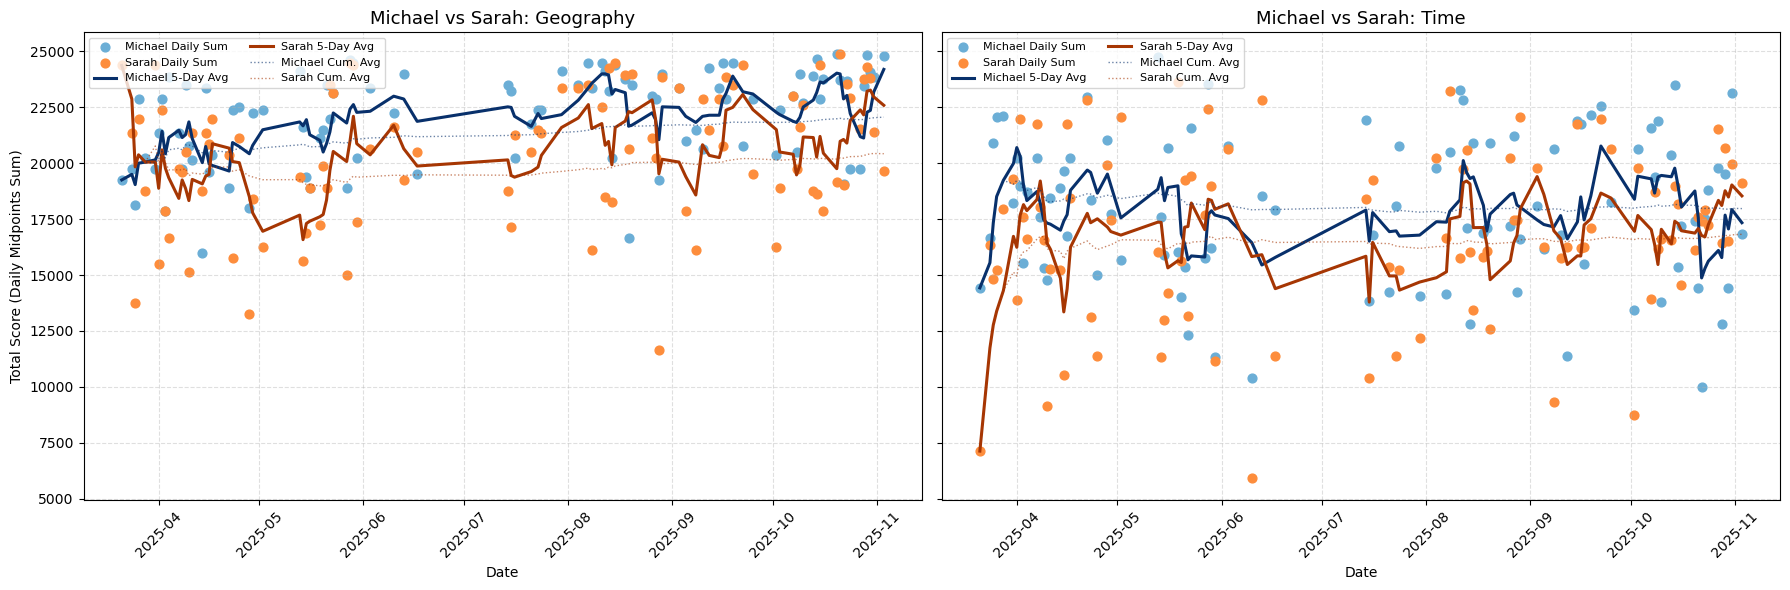

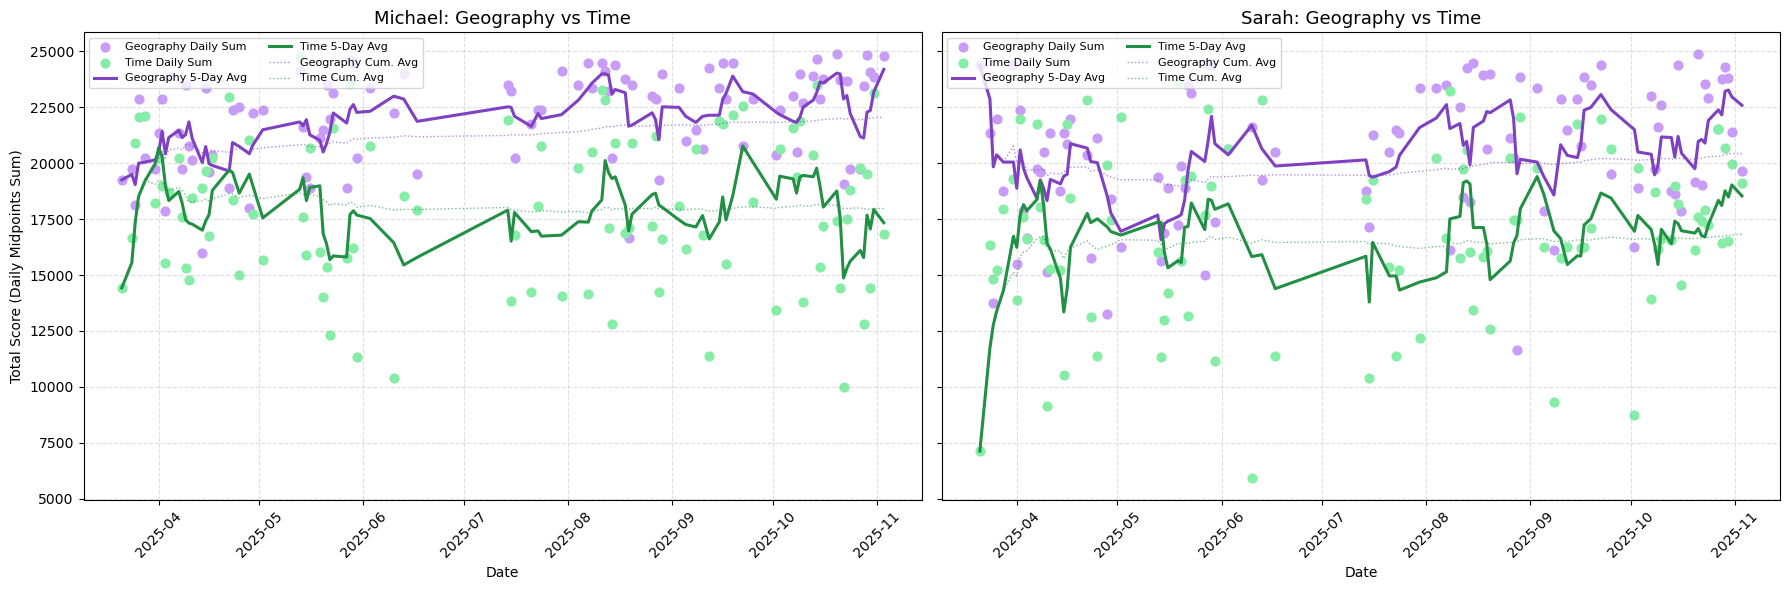

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare data ---
df_plot = df_all.copy()

df_plot = df_plot.dropna(subset=[
    "Michael Geography Score (Min)", "Michael Geography Score (Max)",
    "Sarah Geography Score (Min)", "Sarah Geography Score (Max)",
    "Michael Time Score (Min)", "Michael Time Score (Max)",
    "Sarah Time Score (Min)", "Sarah Time Score (Max)"
])

df_plot["Date"] = pd.to_datetime(df_plot["Date"])
df_plot = df_plot.sort_values(["Date", "Timeguessr Round"]).reset_index(drop=True)

# --- Compute midpoints per round ---
for category in ["Geography", "Time"]:
    for player in ["Michael", "Sarah"]:
        df_plot[f"{player} {category} Midpoint"] = (
            df_plot[f"{player} {category} Score (Min)"] + df_plot[f"{player} {category} Score (Max)"]
        ) / 2

# --- Sum midpoints per day ---
daily_cols = [
    "Michael Geography Midpoint", "Sarah Geography Midpoint",
    "Michael Time Midpoint", "Sarah Time Midpoint"
]

df_daily = (
    df_plot.groupby("Date")[daily_cols]
    .sum()
    .reset_index()
)

# --- Compute 5-day rolling averages and cumulative averages ---
for category in ["Geography", "Time"]:
    for player in ["Michael", "Sarah"]:
        col = f"{player} {category} Midpoint"
        df_daily[f"{player} {category} 5-Day Avg"] = df_daily[col].rolling(window=5, min_periods=1).mean()
        df_daily[f"{player} {category} Cumulative Avg"] = df_daily[col].expanding().mean()

# ============================
#  FIRST SET: Michael vs Sarah
# ============================

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Geography plot ---
ax = axes[0]
ax.scatter(df_daily["Date"], df_daily["Michael Geography Midpoint"], color='#6baed6', label="Michael Daily Sum", s=40)
ax.scatter(df_daily["Date"], df_daily["Sarah Geography Midpoint"], color='#fd8d3c', label="Sarah Daily Sum", s=40)
ax.plot(df_daily["Date"], df_daily["Michael Geography 5-Day Avg"], color='#08306b', linewidth=2.2, linestyle='-', label="Michael 5-Day Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Geography 5-Day Avg"], color='#a63603', linewidth=2.2, linestyle='-', label="Sarah 5-Day Avg")
# Cumulative average (thin dotted)
ax.plot(df_daily["Date"], df_daily["Michael Geography Cumulative Avg"], color='#08306b', linewidth=1, linestyle=':', alpha=0.6, label="Michael Cum. Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Geography Cumulative Avg"], color='#a63603', linewidth=1, linestyle=':', alpha=0.6, label="Sarah Cum. Avg")
ax.set_title("Michael vs Sarah: Geography", fontsize=13)
ax.set_xlabel("Date")
ax.set_ylabel("Total Score (Daily Midpoints Sum)")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', ncol=2, fontsize=8)
ax.tick_params(axis='x', rotation=45)

# --- Time plot ---
ax = axes[1]
ax.scatter(df_daily["Date"], df_daily["Michael Time Midpoint"], color='#6baed6', label="Michael Daily Sum", s=40)
ax.scatter(df_daily["Date"], df_daily["Sarah Time Midpoint"], color='#fd8d3c', label="Sarah Daily Sum", s=40)
ax.plot(df_daily["Date"], df_daily["Michael Time 5-Day Avg"], color='#08306b', linewidth=2.2, linestyle='-', label="Michael 5-Day Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Time 5-Day Avg"], color='#a63603', linewidth=2.2, linestyle='-', label="Sarah 5-Day Avg")
# Cumulative average (thin dotted)
ax.plot(df_daily["Date"], df_daily["Michael Time Cumulative Avg"], color='#08306b', linewidth=1, linestyle=':', alpha=0.6, label="Michael Cum. Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Time Cumulative Avg"], color='#a63603', linewidth=1, linestyle=':', alpha=0.6, label="Sarah Cum. Avg")
ax.set_title("Michael vs Sarah: Time", fontsize=13)
ax.set_xlabel("Date")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', ncol=2, fontsize=8)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================
#  SECOND SET: Geography vs Time per each player
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Michael plot ---
ax = axes[0]
ax.scatter(df_daily["Date"], df_daily["Michael Geography Midpoint"], color='#c89cf7', label="Geography Daily Sum", s=40)
ax.scatter(df_daily["Date"], df_daily["Michael Time Midpoint"], color='#85eda6', label="Time Daily Sum", s=40)
ax.plot(df_daily["Date"], df_daily["Michael Geography 5-Day Avg"], color='#7f40c2', linewidth=2.2, linestyle='-', label="Geography 5-Day Avg")
ax.plot(df_daily["Date"], df_daily["Michael Time 5-Day Avg"], color='#218f44', linewidth=2.2, linestyle='-', label="Time 5-Day Avg")
# Cumulative averages (thin dotted)
ax.plot(df_daily["Date"], df_daily["Michael Geography Cumulative Avg"], color='#7f40c2', linewidth=1, linestyle=':', alpha=0.6, label="Geography Cum. Avg")
ax.plot(df_daily["Date"], df_daily["Michael Time Cumulative Avg"], color='#218f44', linewidth=1, linestyle=':', alpha=0.6, label="Time Cum. Avg")
ax.set_title("Michael: Geography vs Time", fontsize=13)
ax.set_xlabel("Date")
ax.set_ylabel("Total Score (Daily Midpoints Sum)")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', ncol=2, fontsize=8)
ax.tick_params(axis='x', rotation=45)

# --- Sarah plot ---
ax = axes[1]
ax.scatter(df_daily["Date"], df_daily["Sarah Geography Midpoint"], color='#c89cf7', label="Geography Daily Sum", s=40)
ax.scatter(df_daily["Date"], df_daily["Sarah Time Midpoint"], color='#85eda6', label="Time Daily Sum", s=40)
ax.plot(df_daily["Date"], df_daily["Sarah Geography 5-Day Avg"], color='#7f40c2', linewidth=2.2, linestyle='-', label="Geography 5-Day Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Time 5-Day Avg"], color='#218f44', linewidth=2.2, linestyle='-', label="Time 5-Day Avg")
# Cumulative averages (thin dotted)
ax.plot(df_daily["Date"], df_daily["Sarah Geography Cumulative Avg"], color='#7f40c2', linewidth=1, linestyle=':', alpha=0.6, label="Geography Cum. Avg")
ax.plot(df_daily["Date"], df_daily["Sarah Time Cumulative Avg"], color='#218f44', linewidth=1, linestyle=':', alpha=0.6, label="Time Cum. Avg")
ax.set_title("Sarah: Geography vs Time", fontsize=13)
ax.set_xlabel("Date")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper left', ncol=2, fontsize=8)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\mryvin\AppData\Local\Temp\ipykernel_30632\2208149956.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])


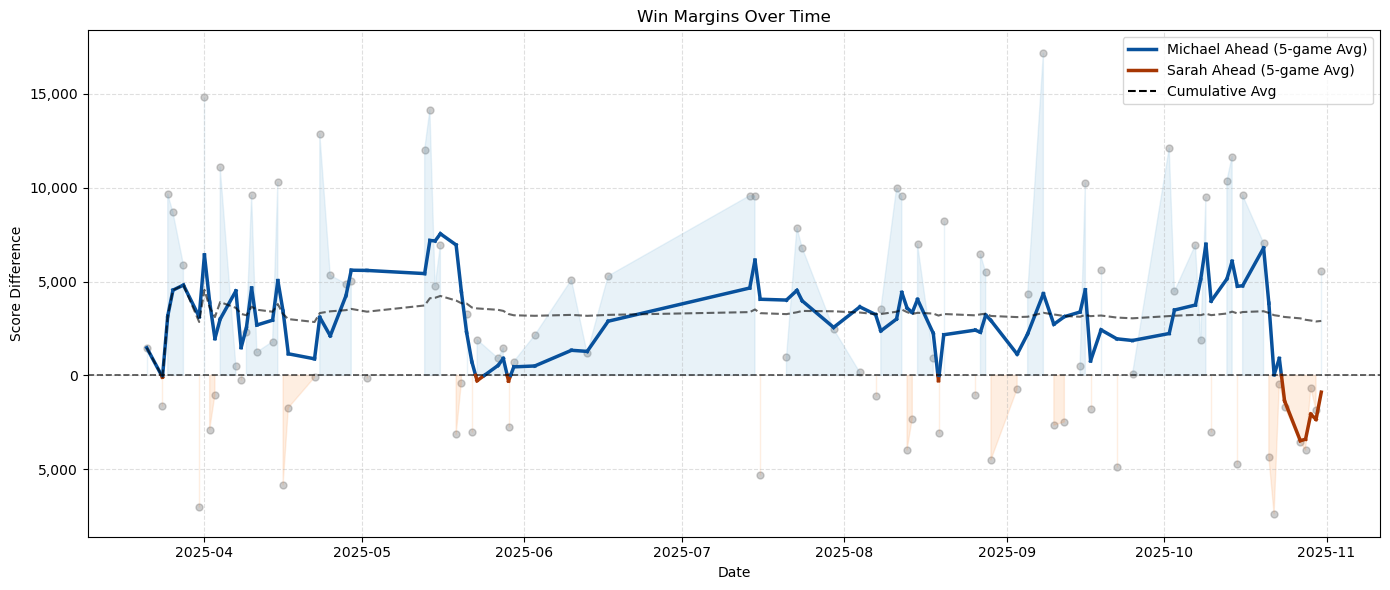

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Prepare data ---
df_daily = df_all.groupby("Timeguessr Day").first().reset_index()
mask = df_daily[["Date", "Michael Total Score", "Sarah Total Score"]].dropna()
mask = mask.sort_values("Date").reset_index(drop=True)

# --- Compute score difference (Michael - Sarah) ---
mask["Score Diff"] = mask["Michael Total Score"] - mask["Sarah Total Score"]

# --- Rolling average (5-game window) ---
mask["Rolling Diff"] = mask["Score Diff"].rolling(window=5, min_periods=1).mean()

# --- Cumulative average ---
mask["Cumulative Diff"] = mask["Score Diff"].expanding().mean()

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(14, 6))

# --- Scatter points ---
ax.scatter(mask["Date"], mask["Score Diff"], color="gray", alpha=0.4, s=25, label="Game Result (Michael − Sarah)")

# --- Shaded regions for wins ---
ax.fill_between(mask["Date"], 0, mask["Score Diff"], where=mask["Score Diff"] > 0, color="#6baed6", alpha=0.15)
ax.fill_between(mask["Date"], 0, mask["Score Diff"], where=mask["Score Diff"] < 0, color="#fd8d3c", alpha=0.15)

# --- Multicolored rolling average line ---
x = mask["Date"].values
y = mask["Rolling Diff"].values

for i in range(1, len(x)):
    y0, y1 = y[i - 1], y[i]
    x0, x1 = x[i - 1], x[i]

    # Check if the line segment crosses zero
    if (y0 >= 0 and y1 >= 0):
        ax.plot([x0, x1], [y0, y1], color="#08519c", linewidth=2.5)
    elif (y0 <= 0 and y1 <= 0):
        ax.plot([x0, x1], [y0, y1], color="#a63603", linewidth=2.5)
    else:
        frac = abs(y0) / (abs(y0) + abs(y1))
        x_cross = x0 + (x1 - x0) * frac
        ax.plot([x0, x_cross], [y0, 0], color="#08519c" if y0 > 0 else "#a63603", linewidth=2.5)
        ax.plot([x_cross, x1], [0, y1], color="#08519c" if y1 > 0 else "#a63603", linewidth=2.5)

# --- Cumulative average line ---
ax.plot(mask["Date"], mask["Cumulative Diff"], color="black", linewidth=1.5, linestyle="--", alpha=0.6, label="Cumulative Avg")

# --- Formatting ---
ax.axhline(0, color="black", linewidth=1.2, linestyle="--", alpha=0.7)
ax.set_title("Win Margins Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Score Difference")

# Make y-axis labels show absolute values
yticks = ax.get_yticks()
ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])

ax.grid(True, linestyle="--", alpha=0.4)

# --- Legend ---
handles = [
    plt.Line2D([], [], color="#08519c", lw=2.5, label="Michael Ahead (5-game Avg)"),
    plt.Line2D([], [], color="#a63603", lw=2.5, label="Sarah Ahead (5-game Avg)"),
    plt.Line2D([], [], color="black", lw=1.5, linestyle="--", label="Cumulative Avg"),
]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()


C:\Users\mryvin\AppData\Local\Temp\ipykernel_30632\3844070652.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])
C:\Users\mryvin\AppData\Local\Temp\ipykernel_30632\3844070652.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])


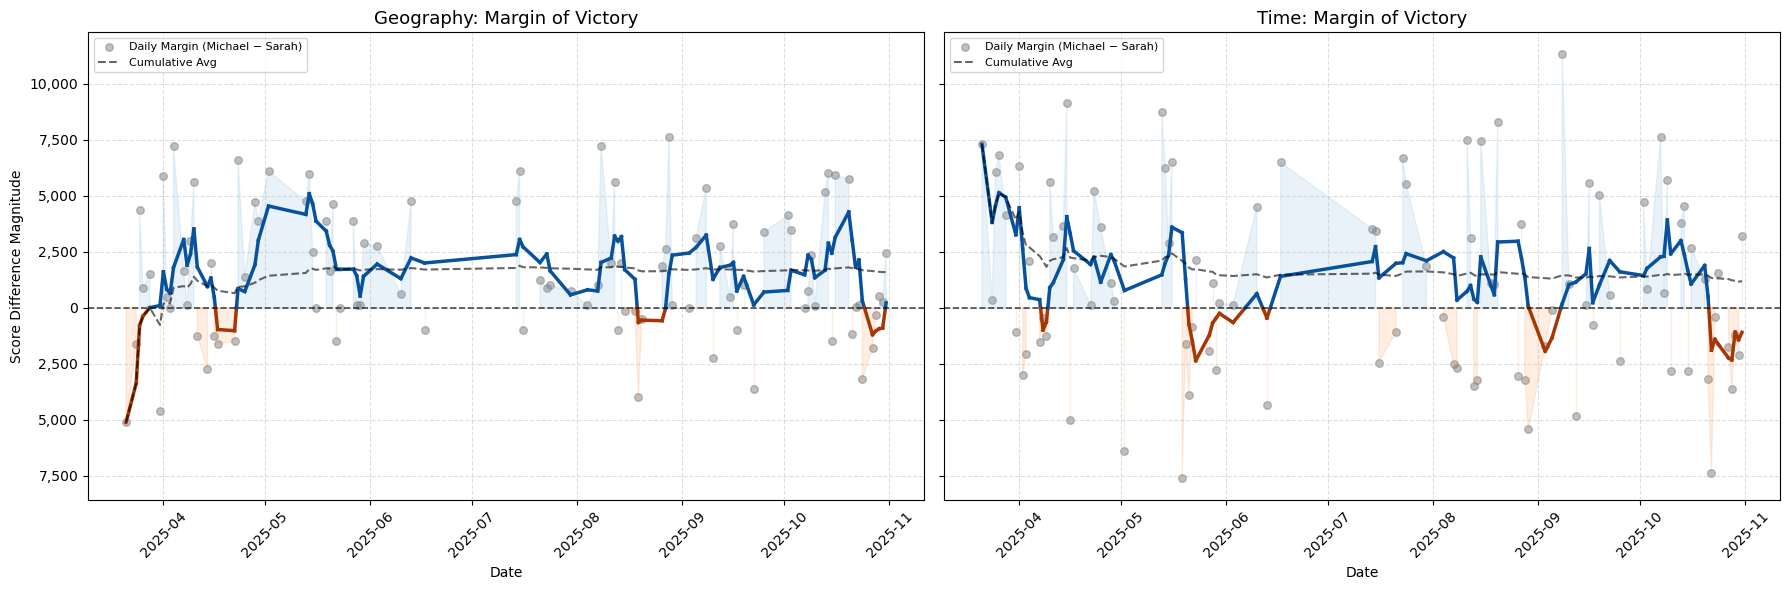

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare data ---
df_plot = df_all.copy()

df_plot = df_plot.dropna(subset=[
    "Michael Geography Score (Min)", "Michael Geography Score (Max)",
    "Sarah Geography Score (Min)", "Sarah Geography Score (Max)",
    "Michael Time Score (Min)", "Michael Time Score (Max)",
    "Sarah Time Score (Min)", "Sarah Time Score (Max)"
])

df_plot["Date"] = pd.to_datetime(df_plot["Date"])
df_plot = df_plot.sort_values(["Date", "Timeguessr Round"]).reset_index(drop=True)

# --- Compute midpoints per round ---
for category in ["Geography", "Time"]:
    for player in ["Michael", "Sarah"]:
        df_plot[f"{player} {category} Midpoint"] = (
            df_plot[f"{player} {category} Score (Min)"] + df_plot[f"{player} {category} Score (Max)"]
        ) / 2

# --- Sum midpoints per day ---
daily_cols = [
    "Michael Geography Midpoint", "Sarah Geography Midpoint",
    "Michael Time Midpoint", "Sarah Time Midpoint"
]

df_daily = (
    df_plot.groupby("Date")[daily_cols]
    .sum()
    .reset_index()
)

# --- Compute margin of victory for each category ---
for category in ["Geography", "Time"]:
    df_daily[f"{category} Margin"] = (
        df_daily[f"Michael {category} Midpoint"] - df_daily[f"Sarah {category} Midpoint"]
    )

# --- Compute rolling and cumulative averages ---
for category in ["Geography", "Time"]:
    df_daily[f"{category} 5-Day Avg"] = df_daily[f"{category} Margin"].rolling(window=5, min_periods=1).mean()
    df_daily[f"{category} Cumulative Avg"] = df_daily[f"{category} Margin"].expanding().mean()

# ============================
#   PLOTS
# ============================

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Helper for multicolored rolling line ---
def plot_multicolor_line(ax, x, y, color_up="#08519c", color_down="#a63603", lw=2.5):
    for i in range(1, len(x)):
        y0, y1 = y[i - 1], y[i]
        x0, x1 = x[i - 1], x[i]
        if (y0 >= 0 and y1 >= 0):
            ax.plot([x0, x1], [y0, y1], color=color_up, linewidth=lw)
        elif (y0 <= 0 and y1 <= 0):
            ax.plot([x0, x1], [y0, y1], color=color_down, linewidth=lw)
        else:
            frac = abs(y0) / (abs(y0) + abs(y1))
            x_cross = x0 + (x1 - x0) * frac
            ax.plot([x0, x_cross], [y0, 0], color=color_up if y0 > 0 else color_down, linewidth=lw)
            ax.plot([x_cross, x1], [0, y1], color=color_up if y1 > 0 else color_down, linewidth=lw)

# --- Geography plot ---
ax = axes[0]
x = df_daily["Date"].values
y = df_daily["Geography Margin"].values

# Scatter points (daily margin)
ax.scatter(df_daily["Date"], y, color="gray", alpha=0.5, s=30, label="Daily Margin (Michael − Sarah)")

# Fill regions
ax.fill_between(df_daily["Date"], 0, y, where=y > 0, color="#6baed6", alpha=0.15)
ax.fill_between(df_daily["Date"], 0, y, where=y < 0, color="#fd8d3c", alpha=0.15)

# Rolling average (multicolor)
plot_multicolor_line(ax, x, df_daily["Geography 5-Day Avg"].values)

# Cumulative average
ax.plot(df_daily["Date"], df_daily["Geography Cumulative Avg"], color="black", linewidth=1.5, linestyle="--", alpha=0.6, label="Cumulative Avg")

# Formatting
ax.axhline(0, color="black", linestyle="--", linewidth=1.2, alpha=0.7)
ax.set_title("Geography: Margin of Victory", fontsize=13)
ax.set_xlabel("Date")
ax.set_ylabel("Score Difference Magnitude")
ax.grid(True, linestyle="--", alpha=0.4)
yticks = ax.get_yticks()
ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])
ax.legend(loc="upper left", fontsize=8)
ax.tick_params(axis="x", rotation=45)

# --- Time plot ---
ax = axes[1]
x = df_daily["Date"].values
y = df_daily["Time Margin"].values

ax.scatter(df_daily["Date"], y, color="gray", alpha=0.5, s=30, label="Daily Margin (Michael − Sarah)")
ax.fill_between(df_daily["Date"], 0, y, where=y > 0, color="#6baed6", alpha=0.15)
ax.fill_between(df_daily["Date"], 0, y, where=y < 0, color="#fd8d3c", alpha=0.15)
plot_multicolor_line(ax, x, df_daily["Time 5-Day Avg"].values)
ax.plot(df_daily["Date"], df_daily["Time Cumulative Avg"], color="black", linewidth=1.5, linestyle="--", alpha=0.6, label="Cumulative Avg")

ax.axhline(0, color="black", linestyle="--", linewidth=1.2, alpha=0.7)
ax.set_title("Time: Margin of Victory", fontsize=13)
ax.set_xlabel("Date")
ax.grid(True, linestyle="--", alpha=0.4)
yticks = ax.get_yticks()
ax.set_yticklabels([f"{abs(int(y)):,}" for y in yticks])
ax.legend(loc="upper left", fontsize=8)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()
